In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import time
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import gym
import pybullet as p
import stage.envs
from stage.tasks.twolink.reaching import TwoLinkReaching
from stage.utils.nn import use_gpu
use_gpu()

In [4]:
H = 100
X = 2
A = 1
K = 10
XA = X + A

In [5]:
class Integrator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.dt = 0.01
        self.X = 2
        self.A = 1
    def forward(self, x, a):
        x_ = torch.zeros_like(x)
        q, v = x[:, 0:1], x[:, 1:]
        q = q + self.dt * v
        v = v + self.dt * a
        x_[:, 0:1] = q
        x_[:, 1:] = v
        return x_
    def unroll(self, x, a_seq, horizon=None):
        B, L, A = a_seq.shape        
        if horizon is None:
            horizon = L
        S = torch.zeros(B, horizon, X + A)
        for n in range(horizon):
            a = a_seq[:, n, :]
            x = self.forward(x, a)
            xa = torch.cat((x,a), dim=1)
            S[:, n, :] = xa

        return S

In [6]:
class Cost(nn.Module):
    def __init__(self):
        super().__init__()
        self.dt = 0.01    
    def forward(self, x, a):
        return x[:, 0:1] ** 2 + 1e-6*a[:, 0:1]

In [7]:
sys = Integrator()
cost = Cost()
x = torch.randn(1, X)

### Single shooting

In [8]:
E = int(K / 10)
mean = torch.zeros(H, A)
var = (200**2)/16*torch.ones(H, A)

clamp = lambda x: torch.max(torch.min(x, 100*torch.ones_like(x)), -100*torch.ones_like(x))
for i in range(5):
    samples = mean.repeat(K, 1, 1) + var.repeat(K, 1, 1) * torch.randn(K, H, A)
    samples = clamp(samples)
    
    S = sys.unroll(x.expand(K, X), samples)
    Sx = S[:, :, :X].view(-1, X)
    Sa = S[:, :, X:X+A].view(-1, A)
    J = cost(Sx, Sa)
    J = J.view(K, -1)
    J = torch.sum(J, dim=1)
    
    print (J[torch.argsort(J)][0])

    elites = samples[torch.argsort(J)][:E]
    new_mean = torch.mean(elites, dim=0)
    new_var = torch.var(elites, dim=0)

    mean = 0.1 * mean + 0.9 * new_mean
    var = 0.1 * var + 0.9 * new_var
    
    if torch.max(var) < 0.001:
        break
    
actions = mean.unsqueeze(0)

tensor(41.6733)
tensor(46196.6016)
tensor(46196.6016)
tensor(46196.6016)
tensor(46196.6016)


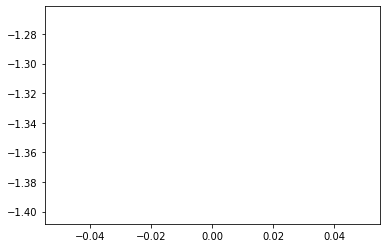

In [9]:
S = sys.unroll(x, actions)
Sx = S[:, :, :X].view(-1, X)
Sx = Sx.detach().cpu().numpy()
plt.plot(Sx)

### Multiple shooting

In [10]:
E = int(K / 100)

mean_x = torch.zeros(H, X)
var_x = (200**2)/16*torch.ones(H, X)
mean_a = torch.zeros(H, A)
var_a = (20**2)/16*torch.ones(H, A)

L = 1
M = int(H/L)
clamp_a = lambda x: torch.max(torch.min(x, 100*torch.ones_like(x)), -100*torch.ones_like(x))
clamp_x = lambda x: torch.max(torch.min(x, 10*torch.ones_like(x)), -10*torch.ones_like(x))

for i in range(5):
    samples_x = mean_x.repeat(K, 1, 1) + var_x.repeat(K, 1, 1) * torch.randn(K, H, X)
    samples_a = mean_a.repeat(K, 1, 1) + var_a.repeat(K, 1, 1) * torch.randn(K, H, A)
    
    samples_x = clamp_x(samples_x)
    samples_a = clamp_a(samples_a)
    
    J = torch.zeros(K)
    
    for m in range(M):
        x0 = samples_x[:, m*L, :]
    
        S = sys.unroll(x0, samples_a, L)
        
        if m < M - 1:
            x_ = S[:, -1, :X]
            x__ = samples_x[:, (m+1)*L, :]
            gap = x_ - x__
            gap_cost = torch.norm(gap, p=2, dim=1)**2
            
        else:
            gap_cost = 0 * torch.norm(gap, p=2, dim=1)**2
        
        Sx = S[:, :, :X].view(-1, X)
        Sa = S[:, :, X:X+A].view(-1, A)

        Jm = cost(Sx, Sa)
        Jm = Jm.view(K, -1)
        Jm = torch.sum(Jm, dim=1) + gap_cost
        print (gap_cost[0], Jm[0])
        J += Jm
        
    print (J[torch.argsort(J)][0])

    elites_x = samples_x[torch.argsort(J)][:E]
    new_mean_x = torch.mean(elites_x, dim=0)
    new_var_x = torch.var(elites_x, dim=0)

    mean_x = 0.1 * mean_x + 0.9 * new_mean_x
    var_x = 0.1 * var_x + 0.9 * new_var_x

    elites_a = samples_a[torch.argsort(J)][:E]
    new_mean_a = torch.mean(elites_a, dim=0)
    new_var_a = torch.var(elites_a, dim=0)

    mean_a = 0.1 * mean_a + 0.9 * new_mean_a
    var_a = 0.1 * var_a + 0.9 * new_var_a

    if torch.max(var_x) < 0.001 and torch.max(var_a) < 0.001:
        break
    
actions = mean_a.unsqueeze(0)

tensor(430.9336) tensor(528.9436)
tensor(445.6205) tensor(460.1814)
tensor(392.7003) tensor(490.7103)
tensor(0.0437) tensor(102.0537)
tensor(407.3871) tensor(509.3971)
tensor(396.0437) tensor(494.0537)
tensor(0.0437) tensor(102.0537)
tensor(404.0437) tensor(506.0537)
tensor(788.7002) tensor(886.7102)
tensor(0.0437) tensor(98.0537)
tensor(396.0437) tensor(494.0537)
tensor(404.0437) tensor(506.0537)
tensor(0.0437) tensor(98.0537)
tensor(0.0437) tensor(98.0537)
tensor(396.0437) tensor(494.0537)
tensor(404.0437) tensor(506.0537)
tensor(407.3871) tensor(505.3971)
tensor(796.7003) tensor(898.7103)
tensor(407.3871) tensor(509.3971)
tensor(396.0437) tensor(494.0537)
tensor(404.0437) tensor(506.0537)
tensor(396.0437) tensor(494.0537)
tensor(796.7003) tensor(898.7103)
tensor(0.0437) tensor(102.0537)
tensor(404.0437) tensor(506.0537)
tensor(407.3871) tensor(505.3971)
tensor(796.7003) tensor(898.7103)
tensor(0.0437) tensor(102.0537)
tensor(407.3871) tensor(509.3971)
tensor(392.7003) tensor(490.710

tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(0.) tensor(102.0101)
tensor(10301.0039)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103.0201)
tensor(1.0100) tensor(103

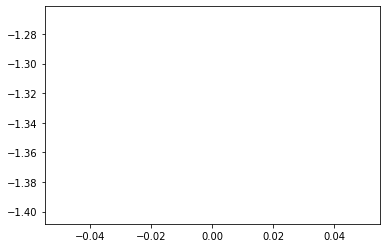

In [11]:
S = sys.unroll(x, actions)
Sx = S[:, :, :X].view(-1, X)
Sx = Sx.detach().cpu().numpy()
plt.plot(Sx)